# Second Competition: Modulation format classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

#import library
from nn_helper_func import *

Load datasets. They are stored as a pickle file.

The datasets are taken from https://www.deepsig.io/datasets (RML2016.10a.tar.bz2), which contains a variety of radio datasets that are available as open datasets. The (simplified and modified, already pre-processed) dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received radio signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

In [2]:
# Load training dataset
with open('Deepsig_dataset_train.pkl', "rb") as f:
    X_train = pickle.load(f)
    y_train = pickle.load(f)
    SNR_train = pickle.load(f)
    modulation_formats = pickle.load(f)
    
# Load validation dataset
with open('Deepsig_dataset_valid.pkl', "rb") as f:
    X_valid = pickle.load(f)
    y_valid = pickle.load(f)
    SNR_valid = pickle.load(f)    

Print modulation formats that are used:

In [4]:
print('Modulation formats: ', modulation_formats)

Modulation formats:  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

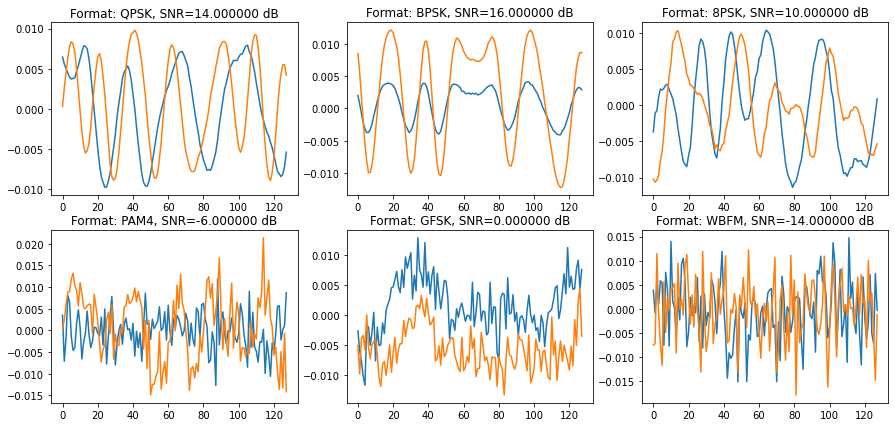

In [5]:
# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train[k+starti,:]))
    plt.plot(np.imag(X_train[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train[k+starti]], SNR_train[k+starti]))

## Task 1: Distinguish between BPSK and GFSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. Try the following two options:
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

Show the classification error for the validation set for each SNR point separately.

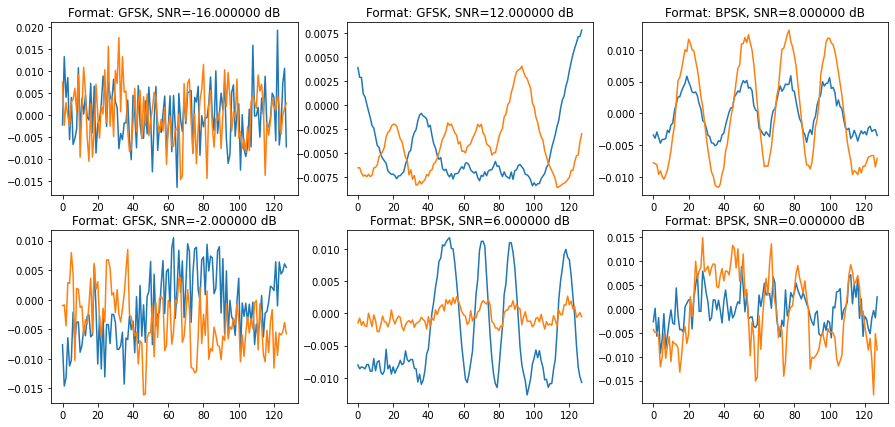

In [6]:
# generate Training set for Task 1
task1_modulation_formatidx = [i for i in range(len(modulation_formats)) if (modulation_formats[i] == 'BPSK' or modulation_formats[i] == 'GFSK')] 

task1_train_idx = [i for i in range(len(y_train)) if (y_train[i] == task1_modulation_formatidx[0] or y_train[i] == task1_modulation_formatidx[1])]
y_train_task1 = y_train[task1_train_idx]
X_train_task1 = X_train[task1_train_idx,:]
SNR_train_task1 = SNR_train[task1_train_idx]

task1_valid_idx = [i for i in range(len(y_valid)) if (y_valid[i] == task1_modulation_formatidx[0] or y_valid[i] == task1_modulation_formatidx[1])]
y_valid_task1 = y_valid[task1_valid_idx]
X_valid_task1 = X_valid[task1_valid_idx,:]
SNR_valid_task1 = SNR_valid[task1_valid_idx]

# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train_task1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task1[k+starti,:]))
    plt.plot(np.imag(X_train_task1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train_task1[k+starti]], SNR_train_task1[k+starti]))

In [10]:
# write your own classification algorithm here

#first shape the data, convert input data from 128 complex number to 256 real number
#from 128 features to 256 features
X     = np.concatenate((X_train_task1.real,X_train_task1.imag),axis=1).transpose()
X     = X /X.max()                  #normalize the input training X.max()
X_val = np.concatenate((X_valid_task1.real,X_valid_task1.imag),axis=1).transpose()
X_val = X_val/X_val.max()           #normalize the input validation

Y     = np.equal(y_train_task1,4)   #set 0 as BPSK and 1 as GFSK
Y     = Y.astype(float)             #convert data type to float
Y     = Y.reshape(-1,1).transpose() #reshape the array
Y_val = np.equal(y_valid_task1,4)
Y_val = Y_val.astype(float)
Y_val = Y_val.reshape(-1,1).transpose()

X_train_SNR=[]
X_valid_SNR=[]
Y_train_SNR=[]
Y_valid_SNR=[]

#variables
alpha = 0.6                       #learning rate  
num_iteration = 10000               #number of iteration
n_H = 20 #number of hidden layers

#divide the data base on SNR
SNR_range = np.unique(SNR_train_task1) #range of SNR from -20 to 18dB
Error_rates = np.zeros(len(SNR_range)) #store the value of error rate for every SNR
Error_rates_train = np.zeros(len(SNR_range))

#loop over all SNR value
for idx,value in enumerate(SNR_range[17:19]):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    #divide data according to its SNR value
    X_train_SNR = X[:,ids_train]
    X_valid_SNR = X_val[:,ids_valid]
    Y_train_SNR = Y[:,ids_train]
    Y_valid_SNR = Y_val[:,ids_valid]
    
    #feed the data to Neural Network model
    params = Neural_Network_model(X_train_SNR,Y_train_SNR,n_H,alpha,num_iteration)
    #make a prediction    
    Y_pred_train = make_prediction(X_train_SNR,params)
    Y_pred = make_prediction(X_valid_SNR,params)    
    
    #calculate the error for every SNR value
    Error_rates_train[idx] = CER(Y_pred_train,Y_train_SNR)
    Error_rates[idx] = CER(Y_pred,Y_valid_SNR)
    
    
    print("Erorr rate for training set ,SNR "+str(value)+" dB = "+str(Error_rates_train[idx]))
    print("Error rate for validation set ,SNR "+str(value)+" dB = "+str(Error_rates[idx])) 
    '''
    print("X_val shape "+str(X_val.shape))
    print("length of ids_train "+str(len(ids_train)))
    print("length of ids_valid "+str(len(ids_valid)))
    print("X_train_SNR shape "+str(X_train_SNR.shape))
    print("Y_train_SNR shape "+str(Y_train_SNR.shape))
    print("Y_pred shape "+str(Y_pred.shape))
    print("X_valid_SNR "+str(X_valid_SNR.shape))
    print("Y_valid_SNR "+str(Y_valid_SNR.shape))      
    print("length of Y_pred "+str(np.size(Y_pred)))
    print("length of Y_valid_SNR "+str(np.size(Y_valid_SNR)))
    '''

Cost after iteration 0: 0.737236
Cost after iteration 100: 0.685239
Cost after iteration 200: 0.667864
Cost after iteration 300: 0.619896
Cost after iteration 400: 0.534022
Cost after iteration 500: 0.481112
Cost after iteration 600: 0.447472
Cost after iteration 700: 0.403211
Cost after iteration 800: 0.359420
Cost after iteration 900: 0.320881
Cost after iteration 1000: 0.283408
Cost after iteration 1100: 0.248918
Cost after iteration 1200: 0.219474
Cost after iteration 1300: 0.193481
Cost after iteration 1400: 0.169690
Cost after iteration 1500: 0.148846
Cost after iteration 1600: 0.131717
Cost after iteration 1700: 0.118104
Cost after iteration 1800: 0.107253
Cost after iteration 1900: 0.098384
Cost after iteration 2000: 0.090899
Cost after iteration 2100: 0.084390
Cost after iteration 2200: 0.078588
Cost after iteration 2300: 0.073312
Cost after iteration 2400: 0.068441
Cost after iteration 2500: 0.063895
Cost after iteration 2600: 0.059622
Cost after iteration 2700: 0.055590
Cost

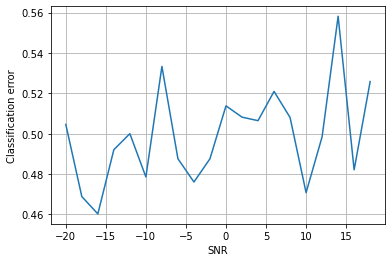

In [13]:


# prepare data, convert complex data to real and imaginary parts
X_train_real = np.column_stack((np.real(X_train_task1), np.imag(X_train_task1)))
X_valid_real = np.column_stack((np.real(X_valid_task1), np.imag(X_valid_task1)))


# generate 0/1 class labels
dic = {task1_modulation_formatidx[0]: 0, task1_modulation_formatidx[1]: 1}
y_train_mod = np.array([dic.get(i) for i in y_train_task1])
y_valid_mod = np.array([dic.get(i) for i in y_valid_task1])


SNR_range = np.unique(SNR_train_task1)
Error_rates = np.zeros(len(SNR_range))

# loop over SNRs
for idx, value in enumerate(SNR_range):
    # pick training and validation examples corresponding to specific SNR
    indices_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    indices_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]

    # dummy classifier ... return random numbers ... can you do betters?    
    valid_est = np.random.randint(low=0,high=2, size=y_valid_mod[indices_valid].shape)
   
    Error_rates[idx] = CER(valid_est, y_valid_mod[indices_valid])

plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [ ]:
# space where you can program your own (better) classifier






## Task 2: Classify modulation format
Design an ML system that estimates the modulation format from the traces (supervised learning, classification task). To evaluate the performance, carry out the classification separately for each SNR and show the performance for each SNR point.
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

## Task 2: Determine SNR
Determine the SNR from the examples (supervised learning, classification task)

## Task 3: Cluster the traces
Try if clustering is successful and if you can group examples that share similar properties (e.g., modulation format and SNR)